In [1]:
# concatenate basin attributes to parameter inputs

import glob
import os
import sys

import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append("../MOASMO_support")
from MOASMO_parameters import *

sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
import NSGA2

# Load data for a basin

In [12]:
# load basin info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [13]:
# load cluster info
infile = "../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt"
df_cluster = pd.read_csv(infile)
df_cluster = df_cluster.rename(
    columns={"Camels_IDs": "hru_id", "flood_cluster": "clusters"}
)
df_cluster2 = pd.DataFrame()

for id in df_info["hru_id"].values:
    dfi = df_cluster.loc[df_cluster["hru_id"] == id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.sel_index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster["clusters"] = df_cluster["clusters"] - 1  # starting from 0

if np.any(df_info["hru_id"].values - df_cluster['hru_id'].values != 0):
    print("Mistmatch between basins and clusters")
else:
    print("basins and clusters match")

basins and clusters match


In [14]:
# load basin attributes for this cluster
attfiles = [
    "/glade/campaign/ral/hap/common/camels/camels_geol.txt",
    "/glade/campaign/ral/hap/common/camels/camels_hydro.txt",
    "/glade/campaign/ral/hap/common/camels/camels_clim.txt",
    "/glade/campaign/ral/hap/common/camels/camels_loc_topo.txt",
    "/glade/campaign/ral/hap/common/camels/camels_soil.txt",
    "/glade/campaign/ral/hap/common/camels/camels_vege.txt",
]

for i in range(len(attfiles)):
    dfi = pd.read_csv(attfiles[i], delimiter=";")
    if i == 0:
        df_att = dfi
    else:
        df_att = pd.merge(df_att, dfi, on="gauge_id")

df_att = df_att.loc[df_att["gauge_id"].isin(df_info["hru_id"].values)]
df_att.sel_index = np.arange(len(df_att))
if np.any(df_att["gauge_id"].values != df_info["hru_id"].values):
    sys.exit("Mismatch between att and info ids")
else:
    df_att["hru_id"] = df_info["hru_id"].values

print("All columns")
print(df_att.columns)

All columns
Index(['gauge_id', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class',
       'glim_2nd_class_frac', 'carbonate_rocks_frac', 'geol_porostiy',
       'geol_permeability', 'q_mean', 'runoff_ratio', 'slope_fdc',
       'baseflow_index', 'stream_elas', 'q5', 'q95', 'high_q_freq',
       'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq', 'hfd_mean',
       'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'high_prec_timing', 'low_prec_freq',
       'low_prec_dur', 'low_prec_timing', 'huc_02', 'gauge_name', 'gauge_lat',
       'gauge_lon', 'mean_elev', 'mean_slope', 'area_gauges2',
       'area_geospa_fabric', 'abs_rel_error_area', 'soil_depth_pelletier',
       'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
       'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
       'water_frac', 'organic_frac', 'other_frac', 'frac_forest', 'lai_max',
       'lai_diff', 'gvf_max', 'gvf_diff', 'dom_land_

Number 45
[467 494 495 496 497 498 508 509 510 511 512 513 514 515 516 517 518 521
 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540
 541 554 609 620 621 622 624 625 626]


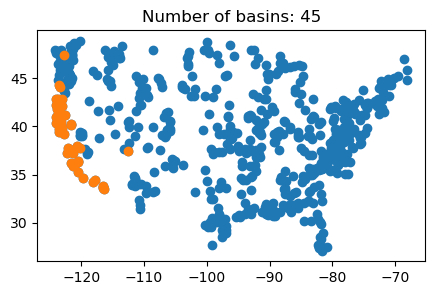

In [15]:
# select a cluster
sel_cluster = 2
sel_index = df_cluster["clusters"].values == sel_cluster
print('Number', np.sum(sel_index))
print(np.where(sel_index)[0])

plt.figure(figsize=[5, 3])
plt.scatter(df_info["lon_cen"], df_info["lat_cen"])
plt.scatter(df_info["lon_cen"].values[sel_index], df_info["lat_cen"].values[sel_index])
plt.title(f"Number of basins: {np.sum(sel_index)}")
plt.show()


In [16]:
# select basin information for this cluster
df_att = df_att[sel_index]
df_cluster = df_cluster[sel_index]
df_info = df_info[sel_index]

# Load priori MO-ASMO outputs (metrics and parameters)

In [17]:
inpath_moasmo = "/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange"
basin_index = np.where(sel_index)[0]

In [18]:
# check whether parameter names are the same
first_parameters = None
all_same = True

for i in basin_index:
    file = (
        f"{inpath_moasmo}/level1_{i}_MOASMOcalib/param_sets/all_default_parameters.pkl"
    )
    df_defaparam = pd.read_pickle(file)
    if first_parameters is None:
        first_parameters = df_defaparam["Parameter"].values
    else:
        if not (df_defaparam["Parameter"].values == first_parameters).all():
            all_same = False
            break

if all_same:
    print("All 'Parameter' values are the same across all files.")
else:
    sys.exit("There are differences in 'Parameter' values between the files.")

print("Parameter names:", first_parameters)

All 'Parameter' values are the same across all files.
Parameter names: ['fff' 'hksat_sf' 'FMAX' 'precip_repartition_nonglc_all_rain_t'
 'n_melt_coef' 'watsat_sf' 'medlynslope' 'd_max' 'zsno' 'zbedrock'
 'sucsat_sf' 'upplim_destruct_metamorph' 'jmaxb0' 'slopebeta']


In [19]:
# load parameter values from all basins

df_param = pd.DataFrame()
df_metric = pd.DataFrame()
param_names = df_defaparam["Parameter"].values  # exclude binded parameters

flag = 0
for i in basin_index:
    file_param = (
        f"{inpath_moasmo}/level1_{i}_MOASMOcalib/ctsm_outputs/iter0_all_meanparam.csv"
    )
    file_metric = (
        f"{inpath_moasmo}/level1_{i}_MOASMOcalib/ctsm_outputs/iter0_all_metric.csv"
    )

    df1 = pd.read_csv(file_param)
    df1 = df1[param_names]

    df2 = pd.read_csv(file_metric)

    df2["basin_num"] = flag
    df2["basin_id"] = i
    df2["hru_id"] = df_info["hru_id"].values[flag]

    if len(df_param) == 0:
        df_param = df1
        df_metric = df2
    else:
        df_param = pd.concat([df_param, df1])
        df_metric = pd.concat([df_metric, df2])

    flag = flag + 1

df_basinid = df_metric[["basin_num", "basin_id", "hru_id"]]
df_metric = df_metric[["metric1", "metric2"]]

print("Number of parameter sets:", len(df_param))

Number of parameter sets: 18000


In [20]:
# parameter upper/lower bound
param_lb_mean = np.array([np.nanmean(v) for v in df_defaparam["Lower"]])
param_ub_mean = np.array([np.nanmean(v) for v in df_defaparam["Upper"]])

# Build emulator and predict optimized parameters for each basin

# attribute selection 

Reference:  
Feng, Dapeng, Kuai Fang, and Chaopeng Shen. "Enhancing streamflow forecast and extracting insights using long‐short term memory networks with data integration at continental scales." Water Resources Research 56, no. 9 (2020): e2019WR026793.

Xie, Kang, Pan Liu, Jianyun Zhang, Dongyang Han, Guoqing Wang, and Chaopeng Shen. "Physics-guided deep learning for rainfall-runoff modeling by considering extreme events and monotonic relationships." Journal of Hydrology 603 (2021): 127043.

Ouyang, Wenyu, Kathryn Lawson, Dapeng Feng, Lei Ye, Chi Zhang, and Chaopeng Shen. "Continental-scale streamflow modeling of basins with reservoirs: Towards a coherent deep-learning-based strategy." Journal of Hydrology 599 (2021): 126455.  

Atts:  

att_Feng2020 = {
    "elev_mean": {"description": "Catchment mean elevation", "unit": "m"},
    "slope_mean": {"description": "Catchment mean slope", "unit": "m/km"},
    "area_gages2": {"description": "Catchment area (GAGESII estimate)", "unit": "km2"},
    "frac_forest": {"description": "Forest fraction", "unit": "—"},
    "lai_max": {"description": "Maximum monthly mean of the leaf area index", "unit": "—"},
    "lai_diff": {"description": "Difference between the maximum and minimum monthly mean of the leaf area index", "unit": "—"},
    "dom_land_cover_frac": {"description": "Fraction of the catchment area associated with the dominant land cover", "unit": "—"},
    "dom_land_cover": {"description": "Dominant land cover type", "unit": "—"},
    "root_depth_50": {"description": "Root depth at 50th percentile, extracted from a root depth distribution based on the International Geosphere-Biosphere Programme (IGBP) land cover", "unit": "m"},
    "soil_depth_statgso": {"description": "Soil depth", "unit": "m"},
    "soil_porosity": {"description": "Volumetric soil porosity", "unit": "—"},
    "soil_conductivity": {"description": "Saturated hydraulic conductivity", "unit": "cm/hr"},
    "max_water_content": {"description": "Maximum water content", "unit": "m"},
    "geol_class_1st": {"description": "Most common geologic class in the catchment basin", "unit": "—"},
    "geol_class_2nd": {"description": "Second most common geologic class in the catchment basin", "unit": "—"},
    "geol_porosity": {"description": "Subsurface porosity", "unit": "—"},
    "geol_permeability": {"description": "Subsurface permeability", "unit": "m2"}
}


att_Xie2021 = {
    "P_mean": {"description": "Mean daily precipitation", "unit": "mm"},
    "Pet_mean": {"description": "Mean daily potential evapotranspiration", "unit": "mm"},
    "Aridity": {"description": "Ratio of mean PET to mean precipitation", "unit": "—"},
    "P_seasonality": {"description": "Seasonality and timing of precipitation", "unit": "mm"},
    "Frac_snow_daily": {"description": "Fraction of precipitation falling on days with temperatures below 0 °C", "unit": "—"},
    "High_prec_freq": {"description": "Frequency of high-precipitation days (≥ 5 times mean daily precipitation)", "unit": "—"},
    "High_prec_dur": {"description": "Average duration of high-precipitation events", "unit": "day"},
    "Low_prec_freq": {"description": "Frequency of dry days (≤ 1 mm/day)", "unit": "—"},
    "Low_prec_dur": {"description": "Average duration of dry periods", "unit": "day"},
    "Elev_mean": {"description": "Catchment mean elevation", "unit": "m"},
    "Slope_mean": {"description": "Catchment mean slope", "unit": "m/km"},
    "Area_gages2": {"description": "Catchment area", "unit": "km2"},
    "Frac_forest": {"description": "Forest fraction", "unit": "—"},
    "Lai_max": {"description": "Maximum monthly mean of leaf area index", "unit": "—"},
    "Lai_diff": {"description": "Difference between the max. and min. mean of the leaf area index", "unit": "—"},
    "Dom_land_cover_frac": {"description": "Fraction of the catchment area associated with the dominant land cover", "unit": "—"},
    "Dom_land_cover": {"description": "Dominant land cover type", "unit": "—"},
    "Soil_depth_pelletier": {"description": "Depth to bedrock (maximum 50 m)", "unit": "m"},
    "Soil_depth_statgso": {"description": "Soil depth (maximum 1.5 m)", "unit": "m"},
    "Soil_porosity": {"description": "Volumetric porosity", "unit": "—"},
    "Soil_conductivity": {"description": "Saturated hydraulic conductivity", "unit": "cm/hr"},
    "Max_water_content": {"description": "Maximum water content of the soil", "unit": "m"},
    "Sand_frac": {"description": "Fraction of sand in the soil", "unit": "—"},
    "Silt_frac": {"description": "Fraction of silt in the soil", "unit": "—"},
    "Clay_frac": {"description": "Fraction of clay in the soil", "unit": "—"},
    "Carb_rocks_frac": {"description": "Fraction of Carbonate sedimentary rocks", "unit": "—"},
    "Geol_permeability": {"description": "Surface permeability (log10)", "unit": "m2"}
}

att_Ouyang2021 = {
    "DRAIN_SQKM": {"description": "Watershed drainage area", "unit": "km2"},
    "ELEV.MEANM_": {"description": "Mean watershed elevation", "unit": "m"},
    "SLOPE_PCT": {"description": "Mean watershed slope", "unit": "%"},
    "STREAMS_KM_S": {"description": "Stream density", "unit": "km of streams per watershed km2"},
    "DEVNLCDO6": {"description": "Watershed percent 'developed' (urban)", "unit": "—"},
    "FORESTNLCDO6": {"description": "Watershed percent 'forest'", "unit": "—"},
    "PLANTNLCDO6": {"description": "Watershed percent 'planted/cultivated' (agriculture)", "unit": "—"},
    "WATERNLCDO6": {"description": "Watershed percent Open Water", "unit": "—"},
    "SNOWICENLCDO6": {"description": "Watershed percent Perennial Ice/Snow", "unit": "—"},
    "BARRENNLCDO6": {"description": "Watershed percent Natural Barren", "unit": "—"},
    "SHRUBNLCDO6": {"description": "Watershed percent Shrubland", "unit": "—"},
    "GRASSNLCDO6": {"description": "Watershed percent Herbaceous (grassland)", "unit": "—"},
    "WOODYWETNLCDO6": {"description": "Watershed percent Woody Wetlands", "unit": "—"},
    "EMERGWETNLCDO6": {"description": "Watershed percent Emergent Herbaceous Wetlands", "unit": "—"},
    "AWCAVE": {"description": "Average value for the range of available water capacity for the soil layer or horizon", "unit": "inches of water per inches of soil depth"}
}



In [21]:
# att names adjusted to raw CAMELS names

att_Feng2020 = {
    "mean_elev": {"description": "Catchment mean elevation", "unit": "m"},
    "mean_slope": {"description": "Catchment mean slope", "unit": "m/km"},
    "area_gauges2": {"description": "Catchment area (GAGESII estimate)", "unit": "km2"},
    "frac_forest": {"description": "Forest fraction", "unit": "—"},
    "lai_max": {
        "description": "Maximum monthly mean of the leaf area index",
        "unit": "—",
    },
    "lai_diff": {
        "description": "Difference between the maximum and minimum monthly mean of the leaf area index",
        "unit": "—",
    },
    "dom_land_cover_frac": {
        "description": "Fraction of the catchment area associated with the dominant land cover",
        "unit": "—",
    },
    "dom_land_cover": {"description": "Dominant land cover type", "unit": "—"},
    "root_depth_50": {
        "description": "Root depth at 50th percentile, extracted from a root depth distribution based on the International Geosphere-Biosphere Programme (IGBP) land cover",
        "unit": "m",
    },
    "soil_depth_statsgo": {"description": "Soil depth", "unit": "m"},
    "soil_porosity": {"description": "Volumetric soil porosity", "unit": "—"},
    "soil_conductivity": {
        "description": "Saturated hydraulic conductivity",
        "unit": "cm/hr",
    },
    "max_water_content": {"description": "Maximum water content", "unit": "m"},
    "geol_1st_class": {
        "description": "Most common geologic class in the catchment basin",
        "unit": "—",
    },
    "geol_2nd_class": {
        "description": "Second most common geologic class in the catchment basin",
        "unit": "—",
    },
    "geol_porostiy": {"description": "Subsurface porosity", "unit": "—"},
    "geol_permeability": {"description": "Subsurface permeability", "unit": "m2"},
}

att_Xie2021 = {
    "p_mean": {"description": "Mean daily precipitation", "unit": "mm"},
    "pet_mean": {
        "description": "Mean daily potential evapotranspiration",
        "unit": "mm",
    },
    "aridity": {"description": "Ratio of mean PET to mean precipitation", "unit": "—"},
    "p_seasonality": {
        "description": "Seasonality and timing of precipitation",
        "unit": "mm",
    },
    "frac_snow": {
        "description": "Fraction of precipitation falling on days with temperatures below 0 °C",
        "unit": "—",
    },
    "high_prec_freq": {
        "description": "Frequency of high-precipitation days (≥ 5 times mean daily precipitation)",
        "unit": "—",
    },
    "high_prec_dur": {
        "description": "Average duration of high-precipitation events",
        "unit": "day",
    },
    "low_prec_freq": {"description": "Frequency of dry days (≤ 1 mm/day)", "unit": "—"},
    "low_prec_dur": {"description": "Average duration of dry periods", "unit": "day"},
    "mean_elev": {"description": "Catchment mean elevation", "unit": "m"},
    "mean_slope": {"description": "Catchment mean slope", "unit": "m/km"},
    "area_gauges2": {"description": "Catchment area", "unit": "km2"},
    "frac_forest": {"description": "Forest fraction", "unit": "—"},
    "lai_max": {"description": "Maximum monthly mean of leaf area index", "unit": "—"},
    "lai_diff": {
        "description": "Difference between the max. and min. mean of the leaf area index",
        "unit": "—",
    },
    "dom_land_cover_frac": {
        "description": "Fraction of the catchment area associated with the dominant land cover",
        "unit": "—",
    },
    "dom_land_cover": {"description": "Dominant land cover type", "unit": "—"},
    "soil_depth_pelletier": {
        "description": "Depth to bedrock (maximum 50 m)",
        "unit": "m",
    },
    "soil_depth_statsgo": {"description": "Soil depth (maximum 1.5 m)", "unit": "m"},
    "soil_porosity": {"description": "Volumetric porosity", "unit": "—"},
    "soil_conductivity": {
        "description": "Saturated hydraulic conductivity",
        "unit": "cm/hr",
    },
    "max_water_content": {
        "description": "Maximum water content of the soil",
        "unit": "m",
    },
    "sand_frac": {"description": "Fraction of sand in the soil", "unit": "—"},
    "silt_frac": {"description": "Fraction of silt in the soil", "unit": "—"},
    "clay_frac": {"description": "Fraction of clay in the soil", "unit": "—"},
    "carbonate_rocks_frac": {
        "description": "Fraction of Carbonate sedimentary rocks",
        "unit": "—",
    },
    "geol_permeability": {"description": "Surface permeability (log10)", "unit": "m2"},
}

In [22]:
# Prepare model input and output

useattrs0 = list(att_Xie2021.keys())
useattrs = []
for i in useattrs0:
    if not isinstance(df_att.iloc[0][i], str):
        useattrs.append(i)


print("The number of attributes used:", len(useattrs))


df_input = df_param.copy()
df_input["hru_id"] = df_basinid["hru_id"]
df_input = df_input.merge(df_att[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
print("Training input names:", inputnames)

df_output = df_metric.copy()

x = df_input[inputnames].values
y = df_output[["metric1", "metric2"]].values

print("Input shape:", x.shape)
print("Output shape:", y.shape)

The number of attributes used: 26
Training input names: ['fff', 'hksat_sf', 'FMAX', 'precip_repartition_nonglc_all_rain_t', 'n_melt_coef', 'watsat_sf', 'medlynslope', 'd_max', 'zsno', 'zbedrock', 'sucsat_sf', 'upplim_destruct_metamorph', 'jmaxb0', 'slopebeta', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'mean_elev', 'mean_slope', 'area_gauges2', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Input shape: (18000, 40)
Output shape: (18000, 2)


# Training the model

## CV of random forest

In [23]:
%%time

random.seed(1234567890)
np.random.seed(1234567890)

n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True)
kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])

y_pred_cv = np.nan * y

for fold_idx, (train_index, test_index) in enumerate(kf.split(x), 1):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize and train your GPR model here; adjust parameters as needed
    sm = RandomForestRegressor()
    sm.fit(x_train, y_train)

    # Predict using the trained model
    y_pred = sm.predict(x_test)  # Adjust this method call based on your model's API
    y_pred_cv[test_index, :] = y_pred

    # Evaluate the model using KGE
    for i in range(y.shape[1]):
        kge_scores[fold_idx - 1, i] = get_modified_KGE(y_test[:, i], y_pred[:, i])

# Calculate the mean KGE score across all folds
mean_kge_score = np.nanmean(kge_scores, axis=0)[np.newaxis, :]
kge_scores = np.concatenate([kge_scores, mean_kge_score])

# Convert the list of KGE scores into a pandas DataFrame
kge_scores_df = pd.DataFrame()
kge_scores_df["Fold"] = list(np.arange(n_splits) + 1) + ["mean"]
kge_scores_df["kge1"] = kge_scores[:, 0]
kge_scores_df["kge2"] = kge_scores[:, 1]
kge_scores_df["kge_mean"] = (kge_scores[:, 0] + kge_scores[:, 1]) / 2

print("RF CV KGE Score for metric1/metric2:")
print(kge_scores_df)

RF CV KGE Score for metric1/metric2:
   Fold      kge1      kge2  kge_mean
0     1  0.992894  0.976897  0.984896
1     2  0.992866  0.973804  0.983335
2     3  0.994141  0.985526  0.989834
3     4  0.992759  0.981334  0.987046
4     5  0.993688  0.981904  0.987796
5  mean  0.993270  0.979893  0.986581
CPU times: user 1min 46s, sys: 182 ms, total: 1min 46s
Wall time: 1min 53s


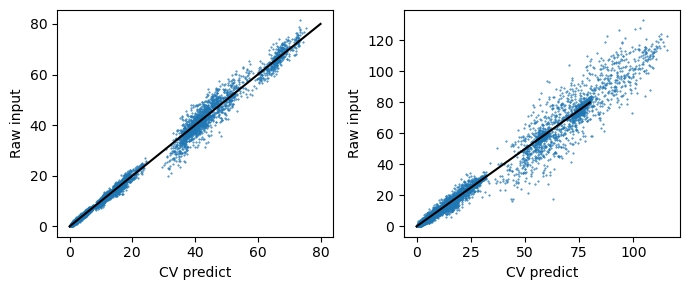

In [24]:
fig = plt.figure(figsize=[7, 3])

for i in range(2):
    fig.add_subplot(1, 2, 1 + i)
    plt.scatter(y_pred_cv[:, i], y[:, i], 0.2)
    plt.plot([0, 80], [0, 80], "k")
    plt.xlabel("CV predict")
    plt.ylabel("Raw input")

plt.tight_layout()
plt.show()

In [25]:
# fewer samples have worse performance
rf_emulator_cv(x[:400, :], y[0:400, :], "/glade/derecho/scratch/guoqiang/test/", 0)

RF CV KGE Score for metric1/metric2:
   Fold      kge1      kge2  kge_mean
0     1  0.642971  0.769621  0.706296
1     2  0.606473  0.796297  0.701385
2     3  0.554662  0.797346  0.676004
3     4  0.605931  0.737947  0.671939
4     5  0.621368  0.727794  0.674581
5  mean  0.606281  0.765801  0.686041


,Fold,kge1,kge2,kge_mean
0,1,0.642971,0.769621,0.706296
1,2,0.606473,0.796297,0.701385
2,3,0.554662,0.797346,0.676004
3,4,0.605931,0.737947,0.671939
4,5,0.621368,0.727794,0.674581
5,mean,0.606281,0.765801,0.686041


### Spatial CV: Train in some basins and test in the remaining basins 
Check whether the model can be used for parameter estimation in ungauged basins

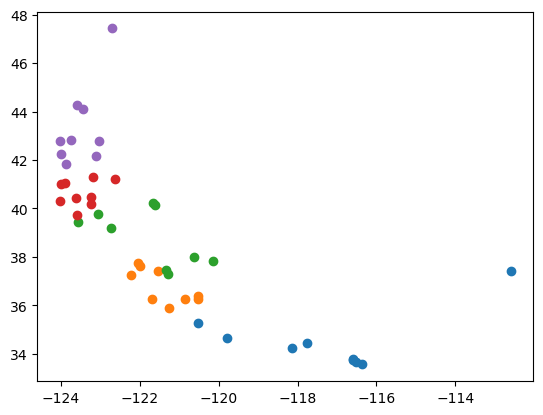

In [26]:
n_splits = 5
n_samples = len(df_info)
batch_size = n_samples // n_splits
lat = df_info["lat_cen"].values
lon = df_info["lon_cen"].values

for fold_idx in range(n_splits):
    start_idx = fold_idx * batch_size
    end_idx = (fold_idx + 1) * batch_size if fold_idx != n_splits - 1 else n_samples
    test_index = np.arange(start_idx, end_idx)
    plt.scatter(lon[test_index], lat[test_index])

plt.show()

In [20]:
def rf_emulator_cv_sequentialbatch(x, y, outpath, iterflag):
    random.seed(1234567890)
    np.random.seed(1234567890)

    n_splits = 5
    n_samples = x.shape[0]
    batch_size = n_samples // n_splits

    kge_scores = np.nan * np.zeros([n_splits, y.shape[1]])

    for fold_idx in range(n_splits):
        start_idx = fold_idx * batch_size
        end_idx = (fold_idx + 1) * batch_size if fold_idx != n_splits - 1 else n_samples

        test_index = np.arange(start_idx, end_idx)
        train_index = np.setdiff1d(np.arange(n_samples), test_index)

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Initialize and train your GPR model here; adjust parameters as needed
        sm = RandomForestRegressor()
        sm.fit(x_train, y_train)

        # Predict using the trained model
        y_pred = sm.predict(x_test)  # Adjust this method call based on your model's API

        # Evaluate the model using KGE
        for i in range(y.shape[1]):
            kge_scores[fold_idx, i] = get_modified_KGE(y_test[:, i], y_pred[:, i])

    # Calculate the mean KGE score across all folds
    mean_kge_score = np.nanmean(kge_scores, axis=0)[np.newaxis, :]
    kge_scores = np.concatenate([kge_scores, mean_kge_score])

    # Convert the list of KGE scores into a pandas DataFrame
    kge_scores_df = pd.DataFrame()
    kge_scores_df["Fold"] = list(np.arange(n_splits) + 1) + ["mean"]
    kge_scores_df["kge1"] = kge_scores[:, 0]
    kge_scores_df["kge2"] = kge_scores[:, 1]
    kge_scores_df["kge_mean"] = (kge_scores[:, 0] + kge_scores[:, 1]) / 2

    print("RF CV KGE Score for metric1/metric2:")
    print(kge_scores_df)

    csv_file_path = f"{outpath}/RF_for_iter{iterflag}_CV_kge.csv"
    kge_scores_df.to_csv(csv_file_path, index=False)

    return kge_scores_df


outpath_temp = '/glade/derecho/scratch/guoqiang/tmp'
rf_kge_cv = rf_emulator_cv_sequentialbatch(x, y, outpath_temp, 0)

RF CV KGE Score for metric1/metric2:
   Fold      kge1      kge2  kge_mean
0     1 -2.348792 -1.394067 -1.871429
1     2 -0.066099  0.120445  0.027173
2     3  0.792913  0.688240  0.740577
3     4  0.590421  0.656226  0.623324
4     5  0.627099  0.744915  0.686007
5  mean -0.080892  0.163152  0.041130


## train all basins within a cluster with basin attributes as inputs (i.e., additional parameters)

### RF

In [27]:
%%time

file_sm_rf_all = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_rf_allbasin_cluster{sel_cluster}'
if os.path.isfile(file_sm_rf_all):
    with open(file_sm_rf_all, 'rb') as file:
        sm_rf_all = pickle.load(file)
else:
    sm_rf_all = RandomForestRegressor()
    sm_rf_all.fit(x, y)
    pickle.dump(sm_rf_all, open(file_sm_rf_all, 'wb'))

CPU times: user 162 ms, sys: 168 ms, total: 329 ms
Wall time: 434 ms


In [28]:
%%time

file_sm_rf_optmz = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_rf_allbasin_cluster{sel_cluster}_optmz_outputs.npz'
if os.path.isfile(file_sm_rf_optmz):
    d = np.load(file_sm_rf_optmz)
    bestx_sm_all_rf = d['bestx_sm_all_rf']
    besty_sm_all_rf = d['besty_sm_all_rf']

else:

    bestx_sm_all_rf = []
    besty_sm_all_rf = []
    
    for tarbasin in range(len(df_info)):
        print(tarbasin)
    
        index = np.where(df_basinid["basin_num"].values == tarbasin)[0]
        hruid = df_basinid["hru_id"].values[index[0]]
        attrvalues = df_att.loc[df_att["gauge_id"] == hruid][useattrs].values[0]
    
        x_tar = x[index, :]
        y_tar = y[index, :]
        xlb_mean = np.hstack([param_lb_mean, attrvalues])
        xub_mean = np.hstack([param_ub_mean, attrvalues])
    
        nInput = len(xlb_mean)
        nOutput = 2
    
        pop = 100
        gen = 100
        crossover_rate = 0.9
        mu = 20
        mum = 20
    
        # define hyperparameter
        alpha = 1e-3
        leng_lb = 1e-3
        leng_ub = 1e3
        nu = 2.5
    
        bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(
            sm_rf_all,
            nInput,
            nOutput,
            xlb_mean,
            xub_mean,
            pop,
            gen,
            crossover_rate,
            mu,
            mum,
        )
        # D = NSGA2.crowding_distance(besty_sm)
        # print('model sample number:', D.shape[0])
    
        bestx_sm_all_rf.append(bestx_sm)
        besty_sm_all_rf.append(besty_sm)

    np.savez_compressed(file_sm_rf_optmz, bestx_sm_all_rf=bestx_sm_all_rf, besty_sm_all_rf=besty_sm_all_rf)

CPU times: user 8.84 ms, sys: 37 µs, total: 8.88 ms
Wall time: 42 ms


### GPR

In [29]:
%%time

file_sm_gpr_all = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_gpr_allbasin_cluster{sel_cluster}'
if os.path.isfile(file_sm_gpr_all):
    with open(file_sm_gpr_all, 'rb') as file:
        sm_gpr_all = pickle.load(file)
else:

    # train over all basins: GRP
    xlb_mean = np.min(x, axis=0)
    xub_mean = np.max(x, axis=0)
    
    xlb_mean[: len(param_lb_mean)] = param_lb_mean
    xub_mean[: len(param_ub_mean)] = param_ub_mean
    
    ind = np.where((xlb_mean == 0) & (xub_mean == 0))
    xlb_mean[ind] = -0.01
    xub_mean[ind] = 0.01
    
    # use sparse samples
    np.random.seed(1234567890)
    index_sparsegpr = np.random.choice(x.shape[0], 5000, replace=False)
    
    # define hyperparameter
    alpha = 1e-3
    leng_lb = 1e-3
    leng_ub = 1e3
    nu = 2.5
    sm_gpr_all = gp.GPR_Matern(
        x[index_sparsegpr, :],
        y[index_sparsegpr,],
        x.shape[1],
        y.shape[1],
        len(index_sparsegpr),
        xlb_mean,
        xub_mean,
        alpha=alpha,
        leng_sb=[leng_lb, leng_ub],
        nu=nu,
    )

    pickle.dump(sm_gpr_all, open(file_sm_gpr_all, 'wb'))

CPU times: user 23.2 ms, sys: 124 ms, total: 147 ms
Wall time: 533 ms


In [30]:
%%time

file_sm_gpr_optmz = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_gpr_allbasin_cluster{sel_cluster}_optmz_outputs.npz'
if os.path.isfile(file_sm_gpr_optmz):
    d = np.load(file_sm_gpr_optmz)
    bestx_sm_all_gpr = d['bestx_sm_all_gpr']
    besty_sm_all_gpr = d['besty_sm_all_gpr']

else:

    bestx_sm_all_gpr = []
    besty_sm_all_gpr = []
    
    for tarbasin in range(len(df_info)):
        print(tarbasin)
    
        index = np.where(df_basinid["basin_num"].values == tarbasin)[0]
        hruid = df_basinid["hru_id"].values[index[0]]
        attrvalues = df_att.loc[df_att["gauge_id"] == hruid][useattrs].values[0]
    
        x_tar = x[index, :]
        y_tar = y[index, :]
        xlb_mean = np.hstack([param_lb_mean, attrvalues])
        xub_mean = np.hstack([param_ub_mean, attrvalues])
    
        nInput = len(xlb_mean)
        nOutput = 2
    
        pop = 100
        gen = 100
        crossover_rate = 0.9
        mu = 20
        mum = 20
    
        bestx_sm, besty_sm, x_sm, y_sm = NSGA2.optimization(
            sm_gpr_all,
            nInput,
            nOutput,
            xlb_mean,
            xub_mean,
            pop,
            gen,
            crossover_rate,
            mu,
            mum,
        )
        # D = NSGA2.crowding_distance(besty_sm)
        # print('model sample number:', D.shape[0])
    
        bestx_sm_all_gpr.append(bestx_sm)
        besty_sm_all_gpr.append(besty_sm)

    np.savez_compressed(file_sm_gpr_optmz, bestx_sm_all_gpr=bestx_sm_all_gpr, besty_sm_all_gpr=besty_sm_all_gpr)

CPU times: user 7.75 ms, sys: 0 ns, total: 7.75 ms
Wall time: 30.8 ms


# Emulator CV based on iter-0

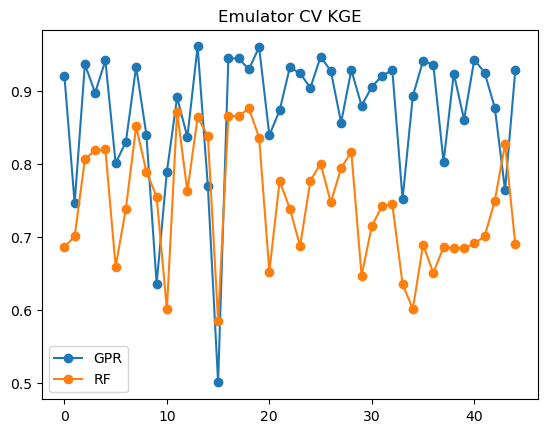

In [35]:
cvkge = np.zeros([len(df_info), 2])
for tarbasin in range(len(df_info)):
    file = f"{inpath_moasmo}/level1_{basin_index[tarbasin]}_MOASMOcalib/param_sets/GPR_for_iter0_CV_kge.csv"
    df1 = pd.read_csv(file)
    cvkge[tarbasin, 0] = df1.values[-1, -1]

    file = f"{inpath_moasmo}/level1_{basin_index[tarbasin]}_MOASMOcalib/param_sets/RF_for_iter0_CV_kge.csv"
    df2 = pd.read_csv(file)
    cvkge[tarbasin, 1] = df2.values[-1, -1]

plt.plot(cvkge[:, 0], "o-", label="GPR")
plt.plot(cvkge[:, 1], "o-", label="RF")
plt.legend()
plt.title("Emulator CV KGE")
plt.show()

# Load model iter-1 metrics from different simulations

In [39]:
# metrics inferred from emulator (trained by basin)

bestx_sm_oneb_gpr = []
besty_sm_oneb_gpr = []
bestx_sm_oneb_rf = []
besty_sm_oneb_rf = []

for tarbasin in range(len(df_info)):
    b = df_basinid.loc[df_basinid['basin_num']==tarbasin]['basin_id'].values[0]

    file = f'{inpath_moasmo}/level1_{b}_MOASMOcalib/GPRout/param_sets/intermediate_output_iter1.pkl.npz'
    dtmp = np.load(file)
    bestx_sm_oneb_gpr.append(dtmp['bestx_sm'])
    besty_sm_oneb_gpr.append(dtmp['besty_sm'])

    file = f'{inpath_moasmo}/level1_{b}_MOASMOcalib/RFout/param_sets/intermediate_output_iter1.pkl.npz'
    dtmp = np.load(file)
    bestx_sm_oneb_rf.append(dtmp['bestx_sm'])
    besty_sm_oneb_rf.append(dtmp['besty_sm'])

    

In [40]:
# metrics inferred from emulator (trained for basins)

file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_rf_allbasin_cluster2_optmz_outputs.npz'
d = np.load(file)
bestx_sm_all_rf = d['bestx_sm_all_rf']
besty_sm_all_rf = d['besty_sm_all_rf']

file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/emulators/emulator_gpr_allbasin_cluster2_optmz_outputs.npz'
d = np.load(file)
bestx_sm_all_gpr = d['bestx_sm_all_gpr']
besty_sm_all_gpr = d['besty_sm_all_gpr']

bestx_sm_oneb_gpr_allb = []
besty_sm_oneb_gpr_allb = []
bestx_sm_oneb_rf_allb = []
besty_sm_oneb_rf_allb = []

n_sample = 40

for tarbasin in range(len(df_info)):
    
    besty_sm = besty_sm_all_rf[tarbasin]
    bestx_sm = bestx_sm_all_rf[tarbasin]
    D = NSGA2.crowding_distance(besty_sm)
    idxr = D.argsort()[::-1][:n_sample]
    bestx_sm_oneb_rf_allb.append(bestx_sm[idxr, :])
    besty_sm_oneb_rf_allb.append(besty_sm[idxr, :])

    besty_sm = besty_sm_all_gpr[tarbasin]
    bestx_sm = bestx_sm_all_gpr[tarbasin]
    D = NSGA2.crowding_distance(besty_sm)
    idxr = D.argsort()[::-1][:n_sample]
    bestx_sm_oneb_gpr_allb.append(bestx_sm[idxr, :])
    besty_sm_oneb_gpr_allb.append(besty_sm[idxr, :])


In [41]:
# metrics from real model runs


def read_one_model(name):

    df_param_iter1_out = pd.DataFrame()
    df_metric_iter1_out = pd.DataFrame()
    
    flag = 0
    
    for i in basin_index:
        
        file_param = f"{inpath_moasmo}/level1_{i}_MOASMOcalib/{name}/ctsm_outputs/iter1_all_meanparam.csv"
        file_metric = f"{inpath_moasmo}/level1_{i}_MOASMOcalib/{name}/ctsm_outputs/iter1_all_metric.csv"
        df1 = pd.read_csv(file_param)
        df1 = df1[param_names]
        df2 = pd.read_csv(file_metric)
        df2["basin_num"] = flag
        df2["basin_id"] = i
        df2["hru_id"] = df_info["hru_id"].values[flag]
        if len(df_param) == 0:
            df_param_iter1_out = df1
            df_metric_iter1_out = df2
        else:
            df_param_iter1_out = pd.concat([df_param_iter1_out, df1])
            df_metric_iter1_out = pd.concat([df_metric_iter1_out, df2])

        flag = flag + 1

    df_basinid_iter1_out = df_metric_iter1_out[["basin_num", "basin_id", "hru_id"]]
    df_metric_iter1_out = df_metric_iter1_out[["metric1", "metric2"]]

    return df_basinid_iter1_out, df_metric_iter1_out


df_basinid_iter1_rf, df_metric_iter1_rf = read_one_model('RFout')
df_basinid_iter1_gpr, df_metric_iter1_gpr = read_one_model('GPRout')
df_basinid_iter1_rf_allb, df_metric_iter1_rf_allb = read_one_model('RF_allbasinemula_out')
df_basinid_iter1_gpr_allb, df_metric_iter1_gpr_allb = read_one_model('GPR_allbasinemula_out')

## compare training over all basins and training over one basin

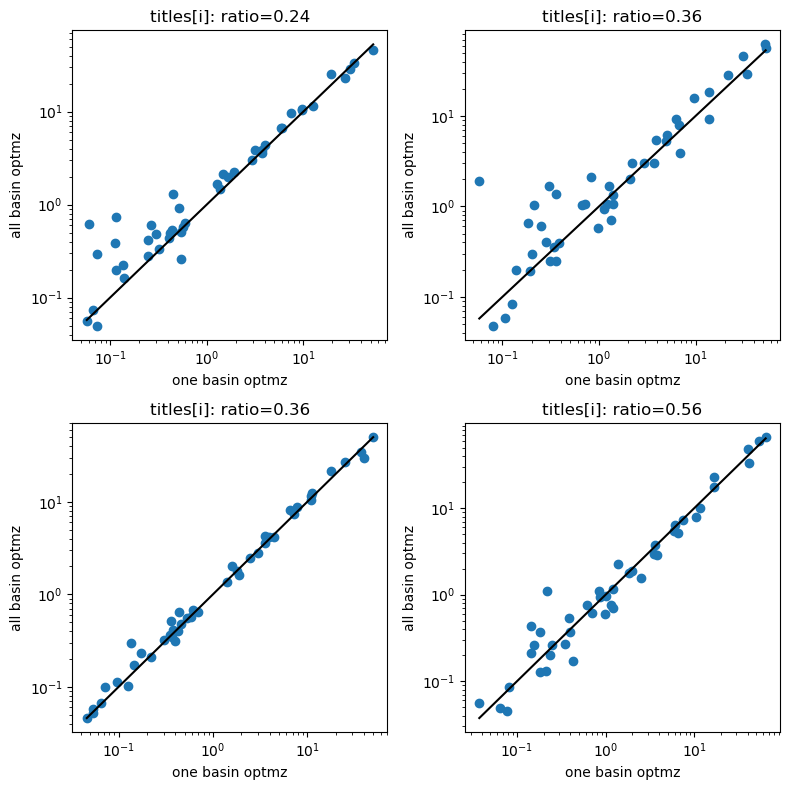

In [80]:
# compare the mean performance: real model

met_rf = np.zeros([len(df_info), 2, 2])
met_gpr = np.zeros([len(df_info), 2, 2])

for tarbasin in range(len(df_info)):
    index2 = np.where(df_basinid_iter1_gpr["basin_num"].values == tarbasin)[0]

    dtmp = df_metric_iter1_gpr.values[index2, :]
    met_gpr[tarbasin, :, 0] = np.nanmedian(dtmp, axis=0)

    dtmp = df_metric_iter1_gpr_allb.values[index2, :]
    met_gpr[tarbasin, :, 1] = np.nanmedian(dtmp, axis=0)

    dtmp = df_metric_iter1_rf.values[index2, :]
    met_rf[tarbasin, :, 0] = np.nanmedian(dtmp, axis=0)

    dtmp = df_metric_iter1_rf_allb.values[index2, :]
    met_rf[tarbasin, :, 1] = np.nanmedian(dtmp, axis=0)


dplot = [ [met_gpr[:,0,0], met_gpr[:,0,1]], 
         [met_gpr[:,1,0], met_gpr[:,1,1]], 
         [met_rf[:,0,0], met_rf[:,0,1]], 
         [met_rf[:,1,0], met_rf[:,1,1]], 
        ]
titles = ['GPR metric-1', 'GPR metric-2', 'RF metric-1', 'RF metric-2']
         


fig = plt.figure(figsize=[8, 8])

for i in range(4):
    fig.add_subplot(2,2,i+1)
    d1 = dplot[i][0]
    d2 = dplot[i][1]
    m1,m2=np.nanmin(d1), np.nanmax(d1)
    plt.plot([m1,m2],[m1,m2],'k')
    plt.scatter(d1, d2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('one basin optmz')
    plt.ylabel('all basin optmz')

    ratio = np.sum(d1>d2)/len(d1) # all basin optimization is better
    plt.title(f"titles[i]: ratio={ratio:.2f}")

plt.tight_layout()
plt.show()

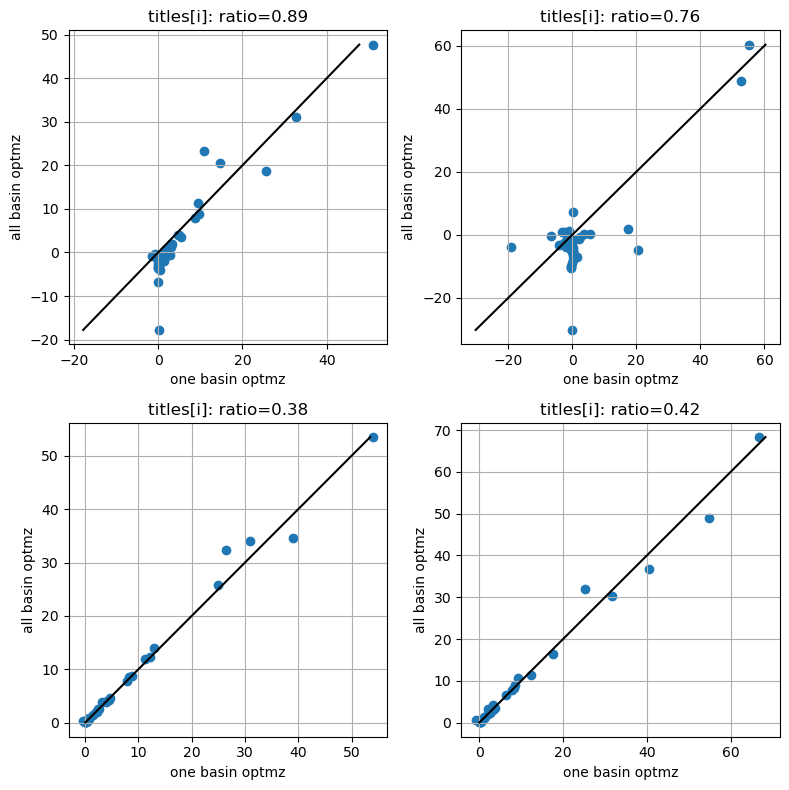

In [88]:
# compare the mean performance: emulator

met_rf = np.zeros([len(df_info), 2, 2])
met_gpr = np.zeros([len(df_info), 2, 2])

for tarbasin in range(len(df_info)):
    index2 = np.where(df_basinid_iter1_gpr["basin_num"].values == tarbasin)[0]

    dtmp = besty_sm_oneb_gpr[tarbasin]
    met_gpr[tarbasin, :, 0] = np.nanmedian(dtmp, axis=0)

    dtmp = besty_sm_all_gpr[tarbasin]
    met_gpr[tarbasin, :, 1] = np.nanmedian(dtmp, axis=0)

    dtmp = besty_sm_oneb_rf[tarbasin]
    met_rf[tarbasin, :, 0] = np.nanmedian(dtmp, axis=0)

    dtmp = besty_sm_all_rf[tarbasin]
    met_rf[tarbasin, :, 1] = np.nanmedian(dtmp, axis=0)


dplot = [ [met_gpr[:,0,0], met_gpr[:,0,1]], 
         [met_gpr[:,1,0], met_gpr[:,1,1]], 
         [met_rf[:,0,0], met_rf[:,0,1]], 
         [met_rf[:,1,0], met_rf[:,1,1]], 
        ]
titles = ['GPR metric-1', 'GPR metric-2', 'RF metric-1', 'RF metric-2']
         

fig = plt.figure(figsize=[8, 8])

for i in range(4):
    fig.add_subplot(2,2,i+1)
    d1 = dplot[i][0]
    d2 = dplot[i][1]
    m1,m2=np.nanmin(d2), np.nanmax(d2)
    plt.plot([m1,m2],[m1,m2],'k')
    plt.scatter(d1, d2)
    plt.xlabel('one basin optmz')
    plt.ylabel('all basin optmz')
    plt.grid('on')

    ratio = np.sum(d1>d2)/len(d1) # all basin optimization is better
    plt.title(f"titles[i]: ratio={ratio:.2f}")

plt.tight_layout()
plt.show()

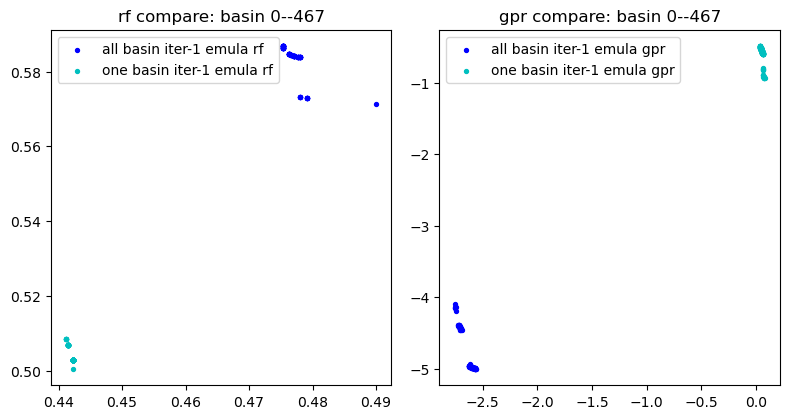

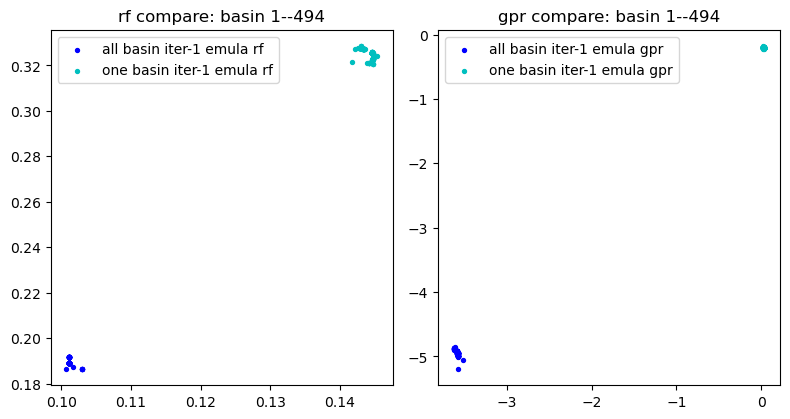

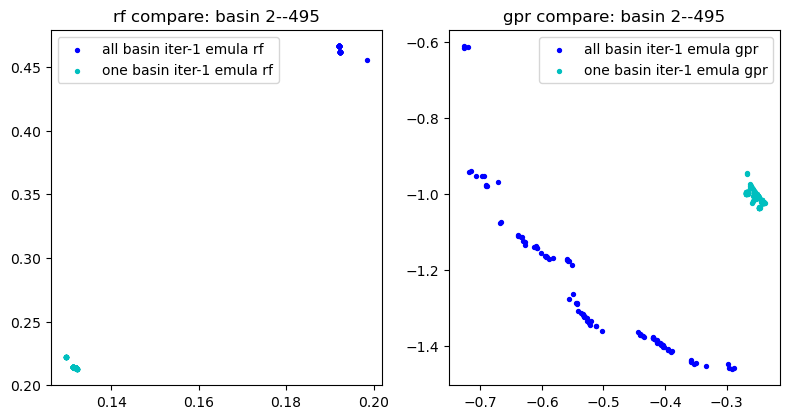

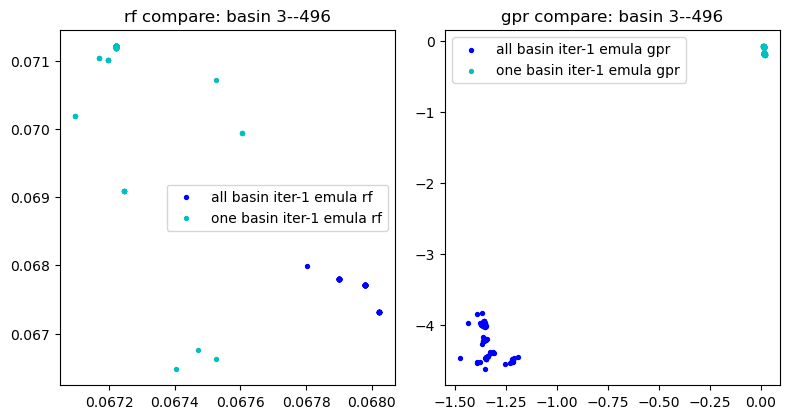

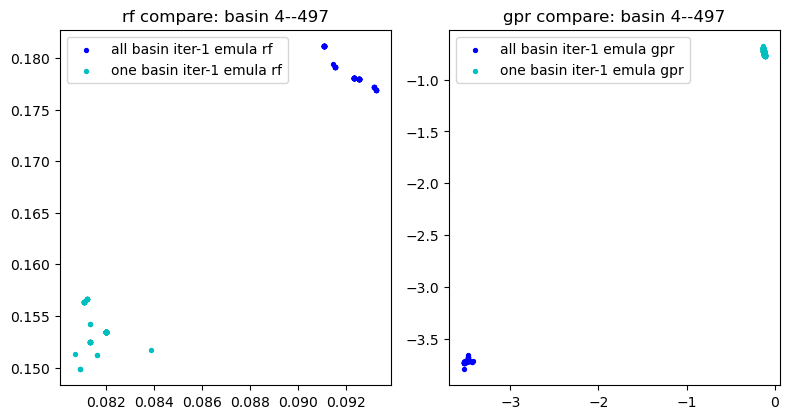

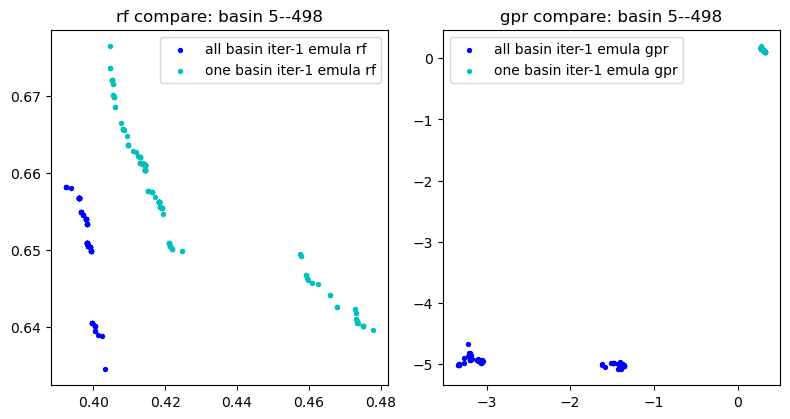

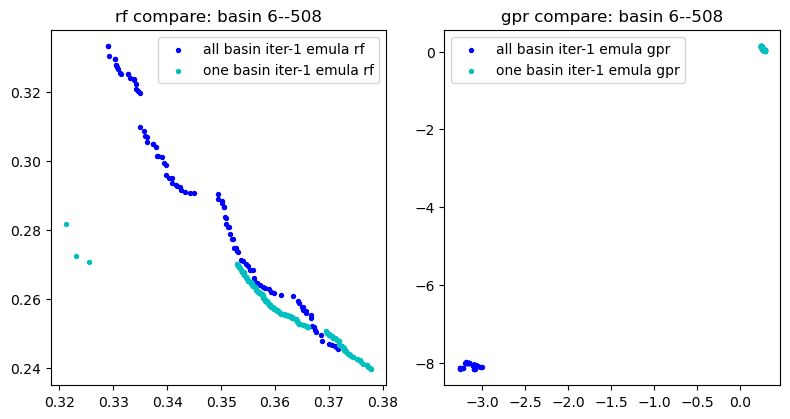

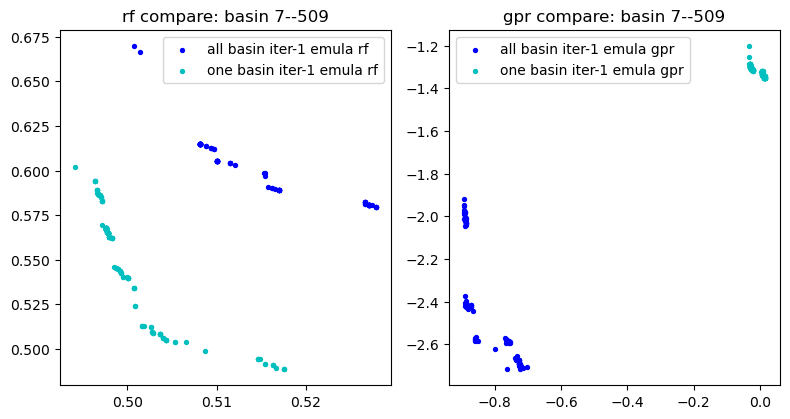

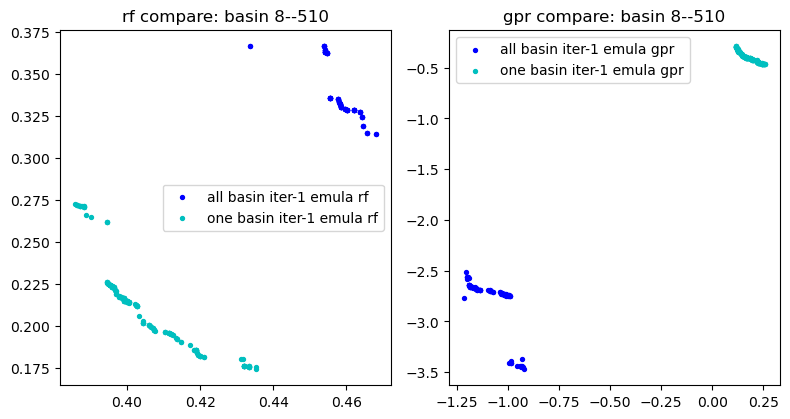

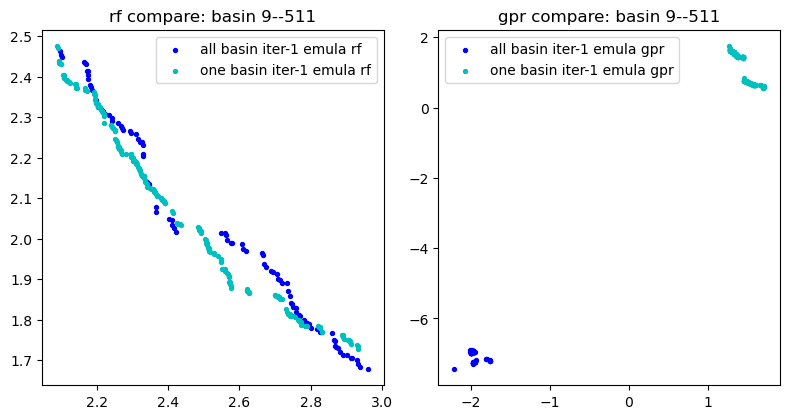

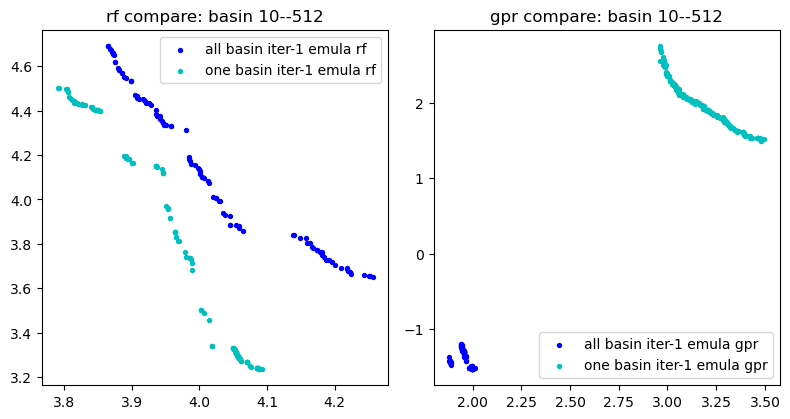

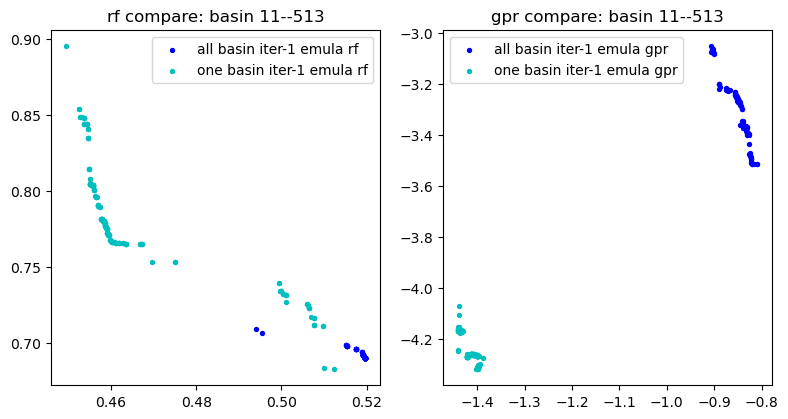

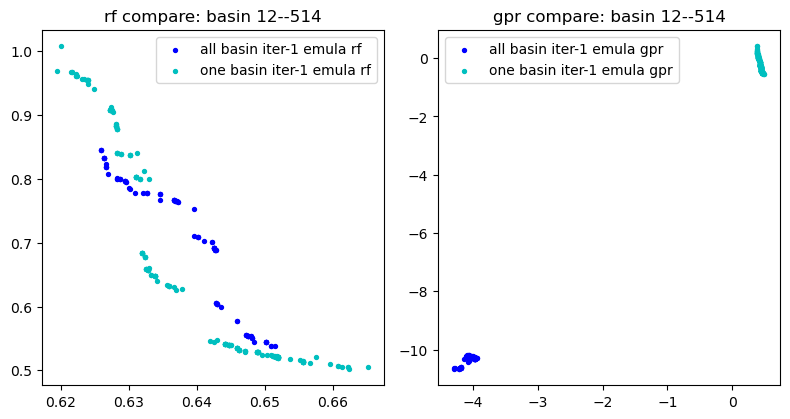

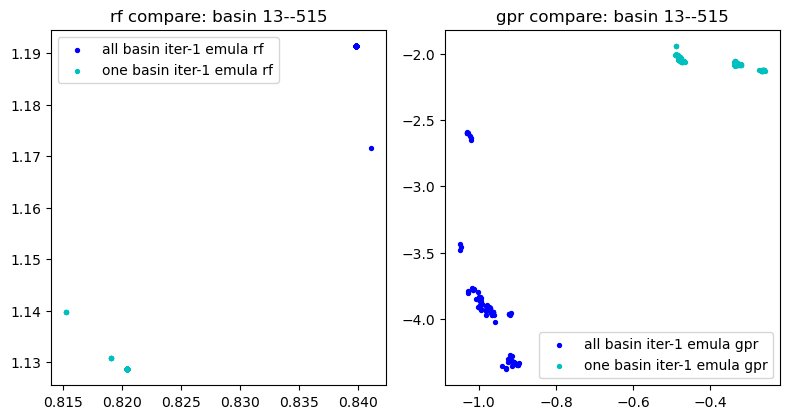

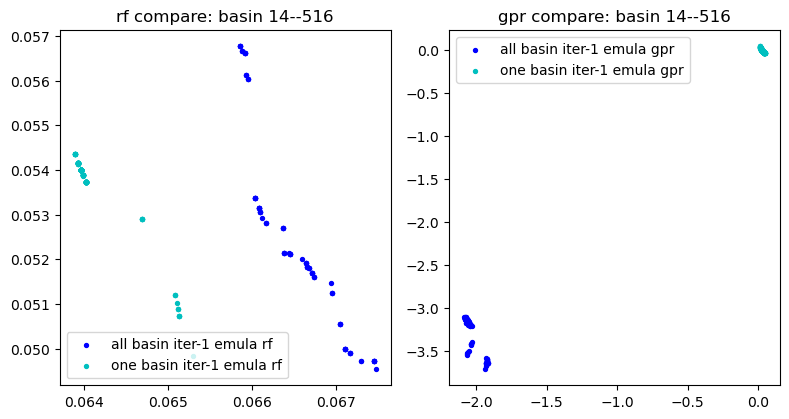

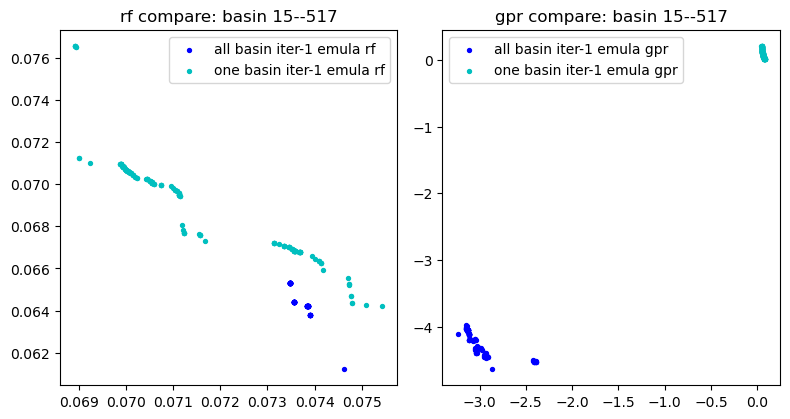

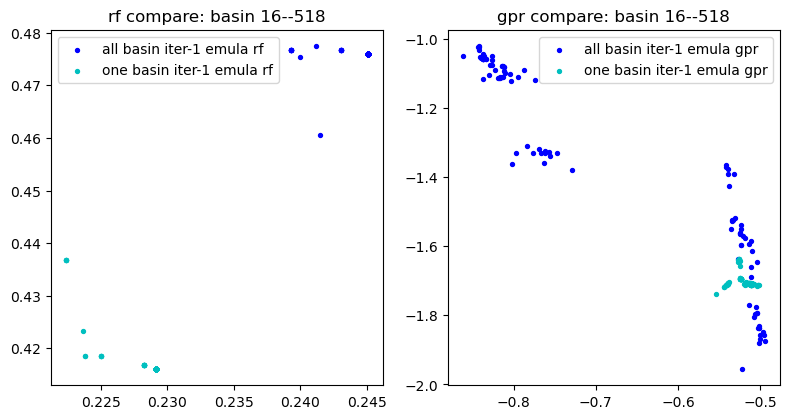

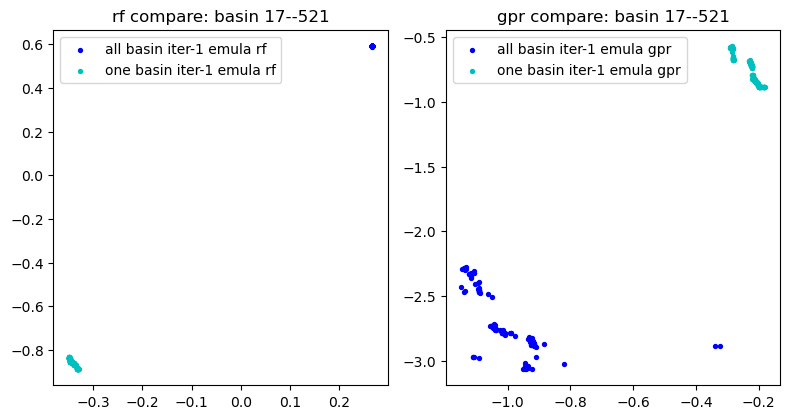

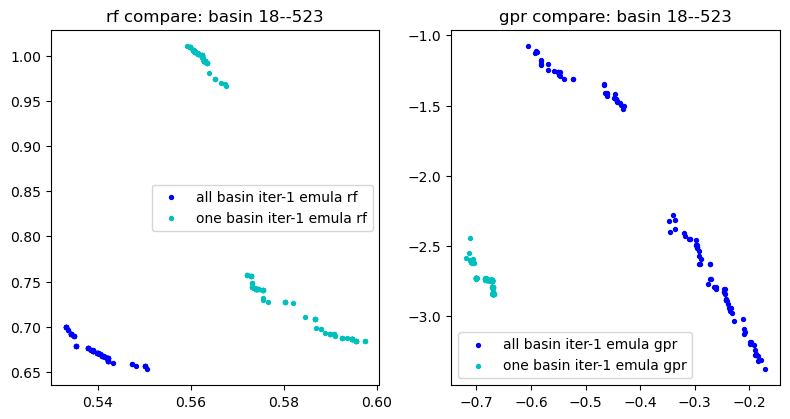

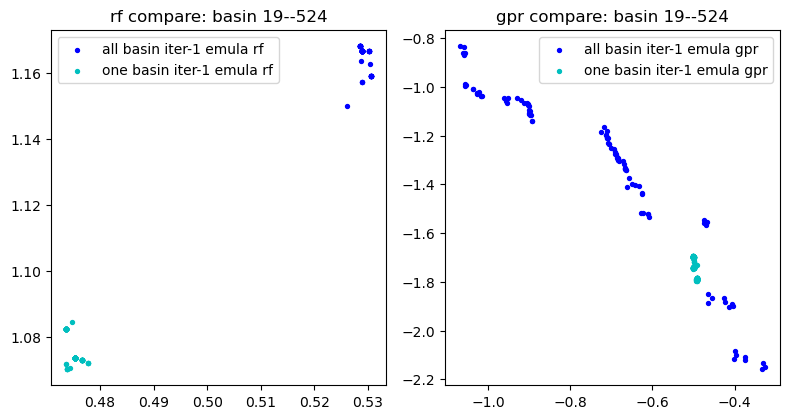

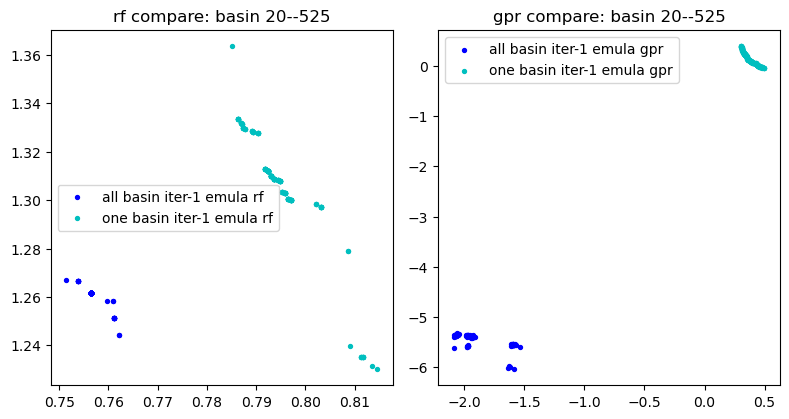

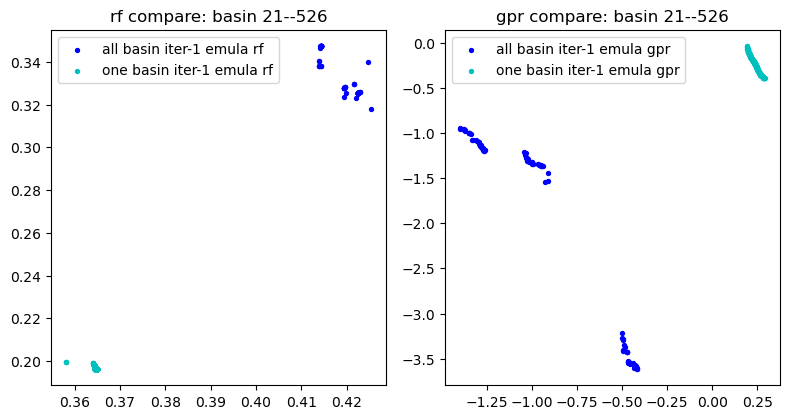

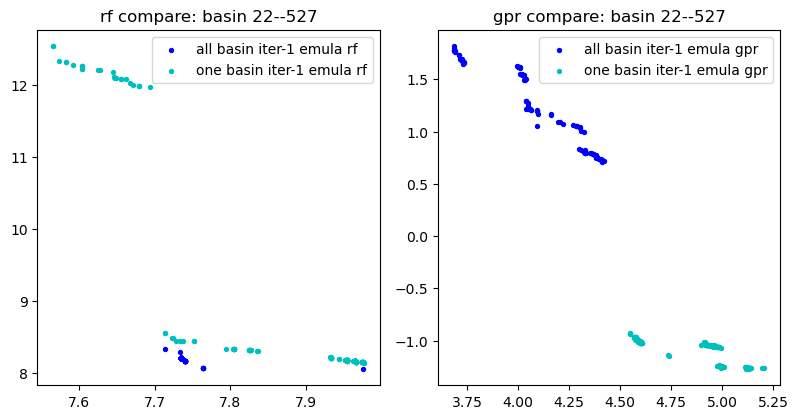

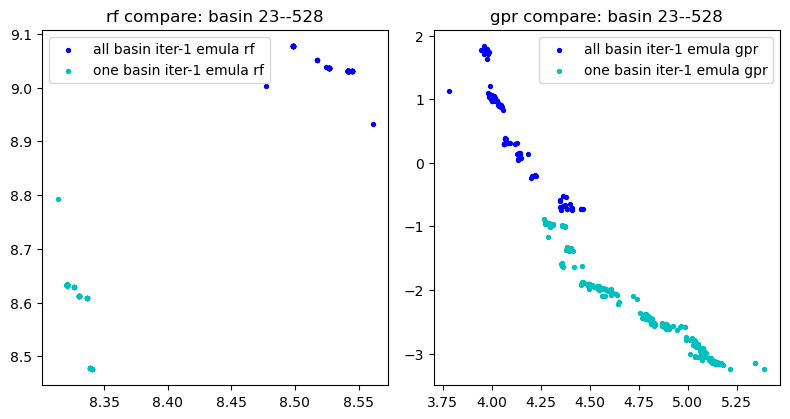

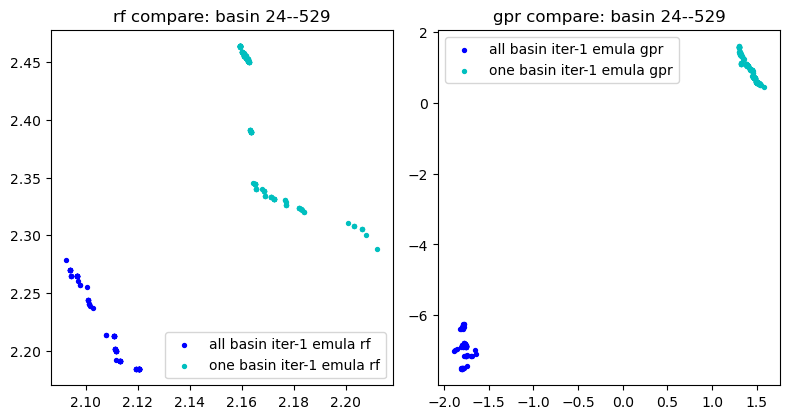

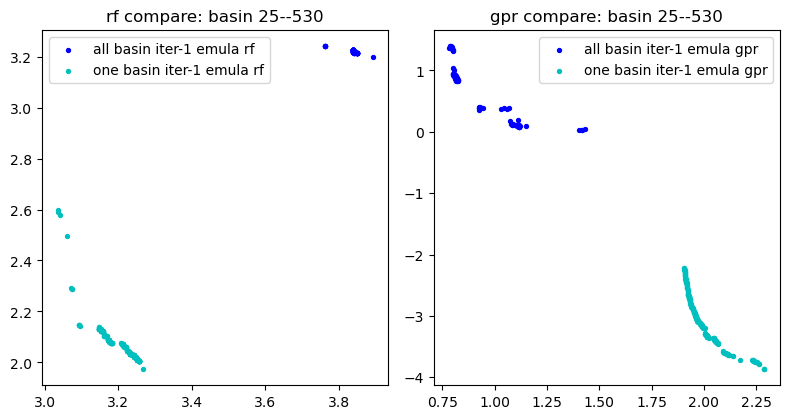

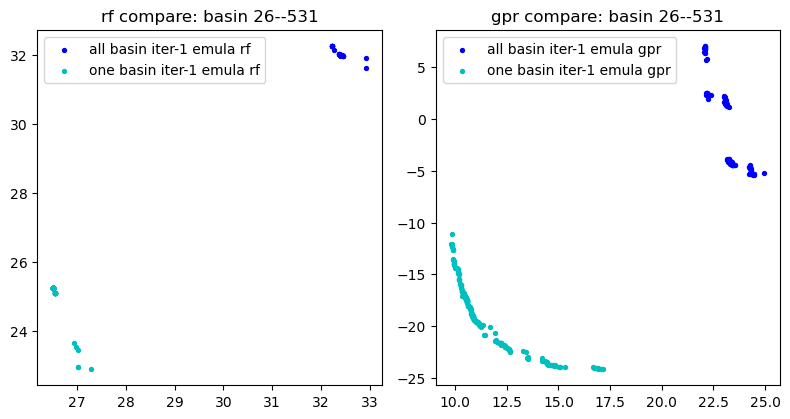

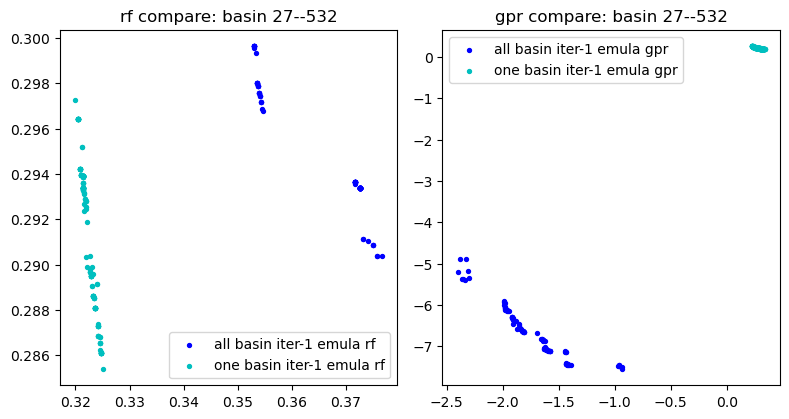

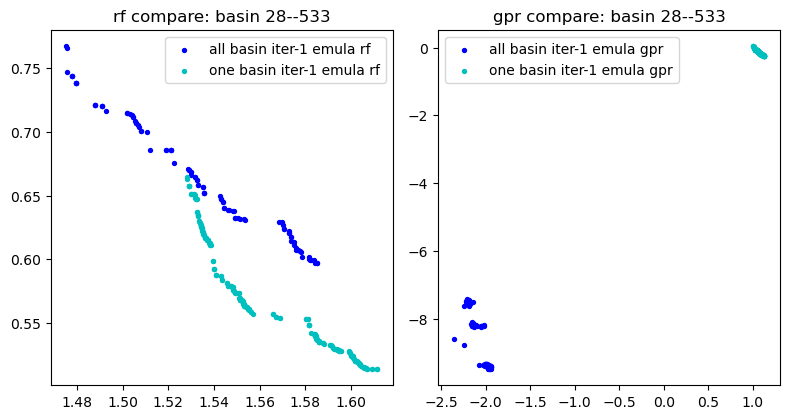

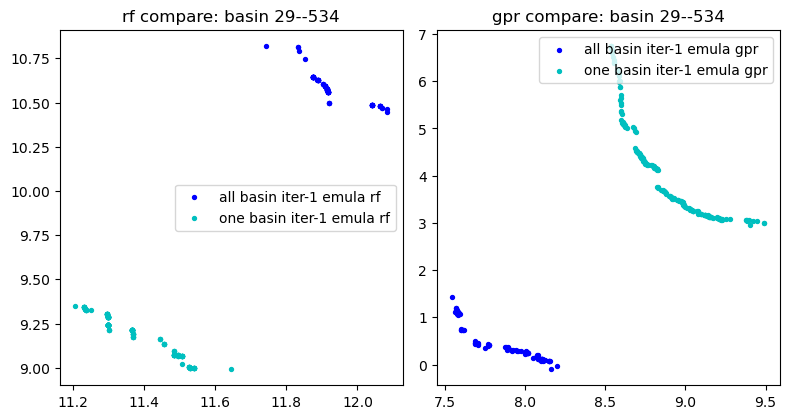

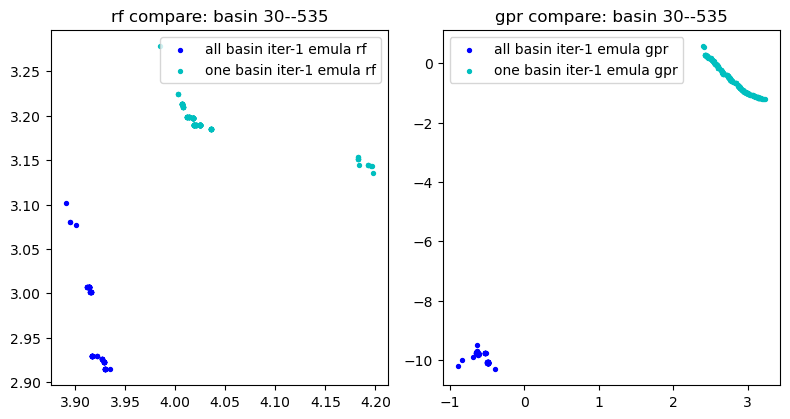

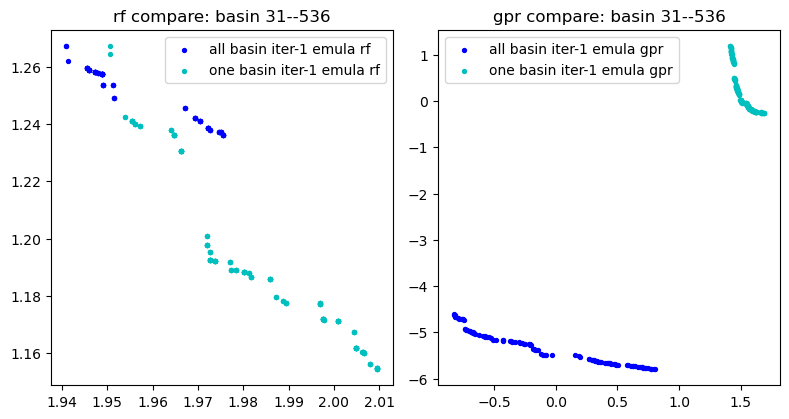

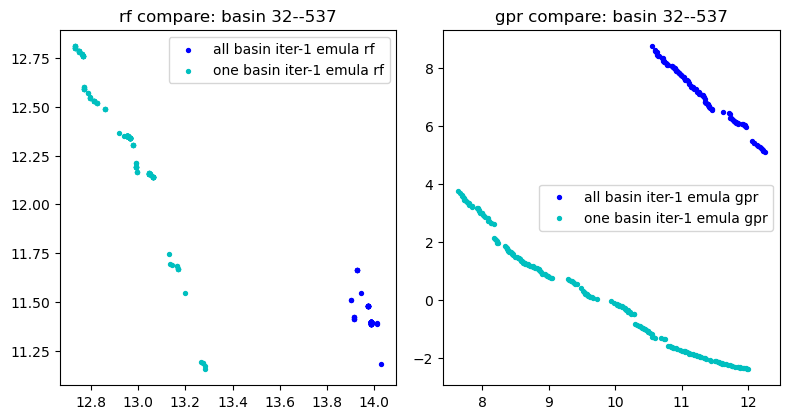

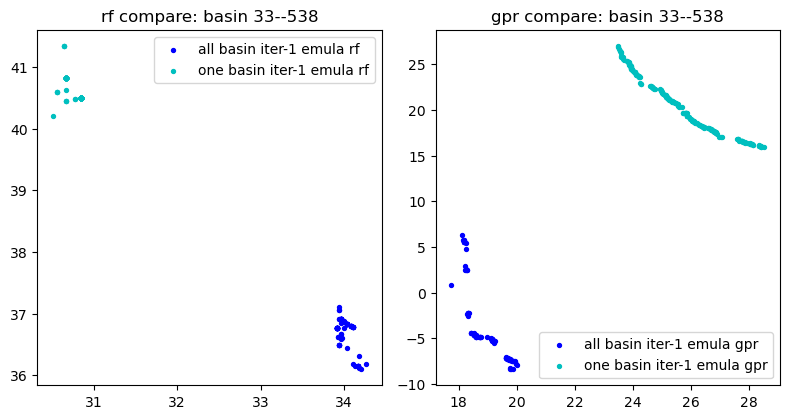

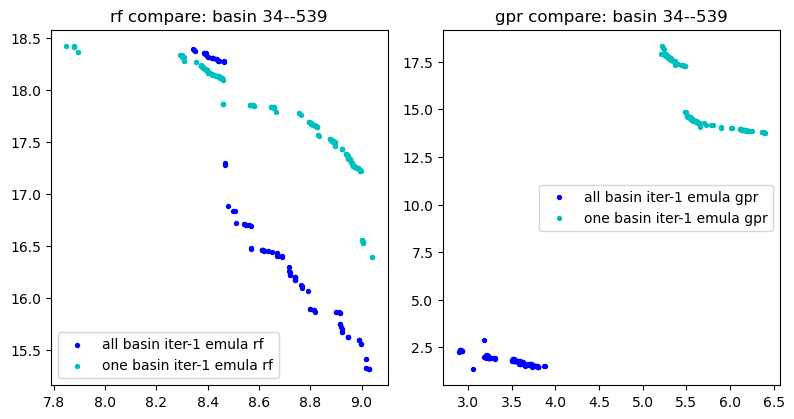

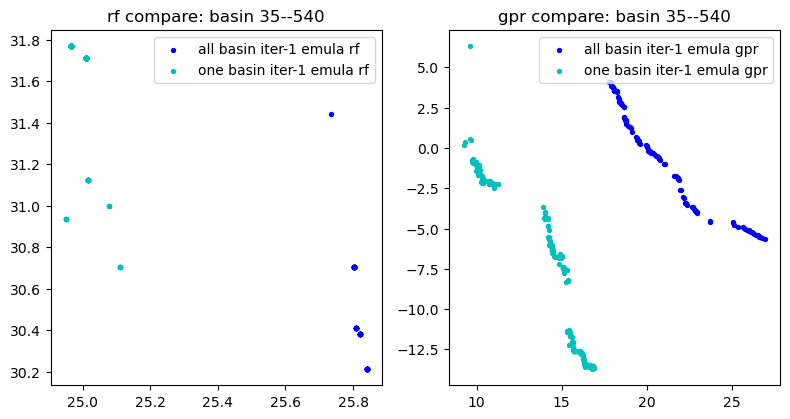

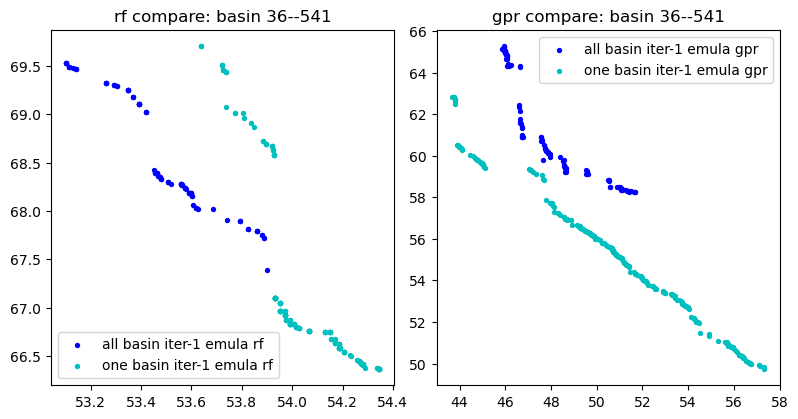

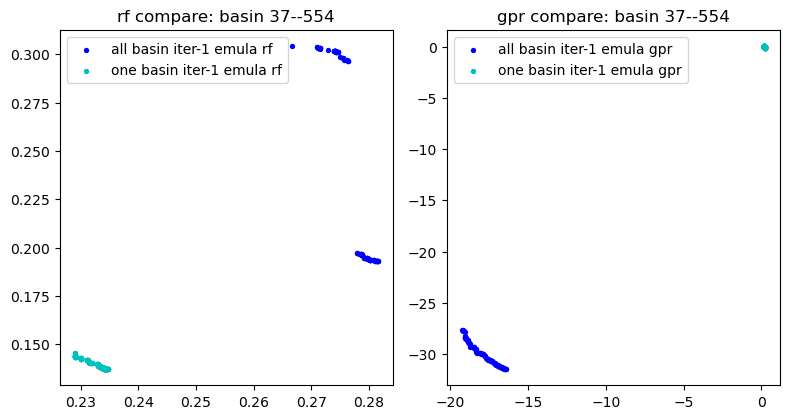

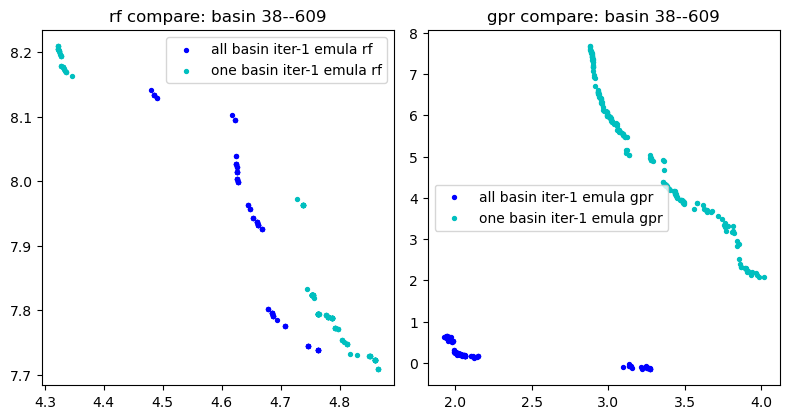

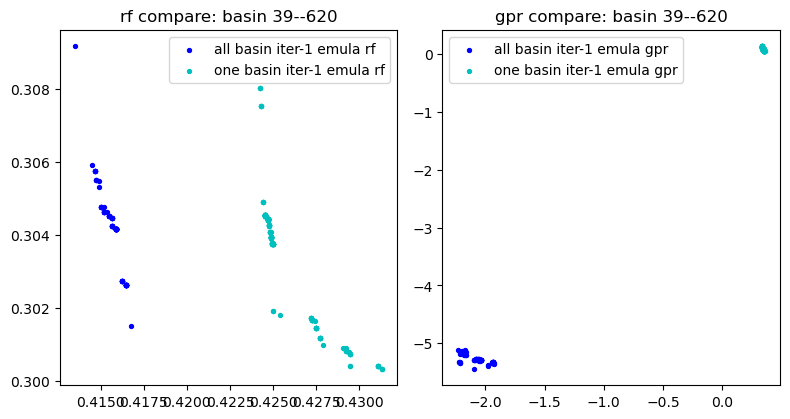

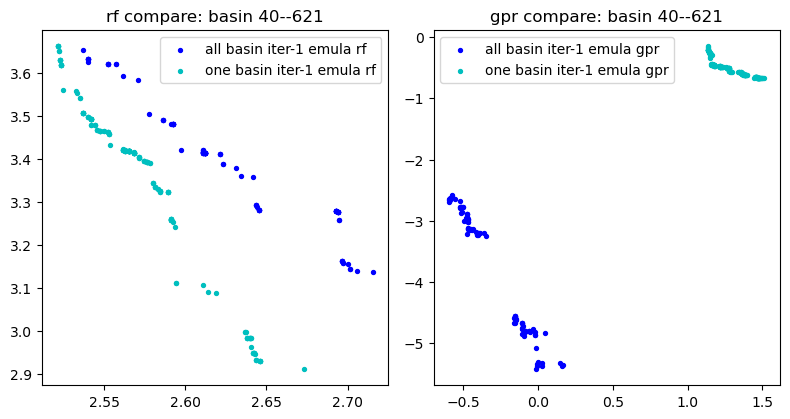

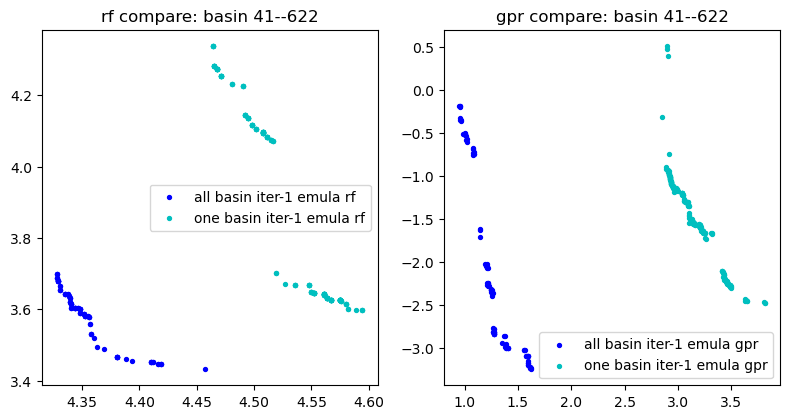

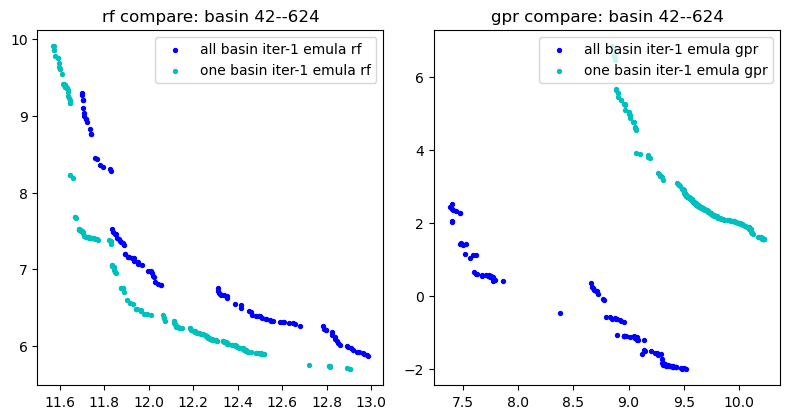

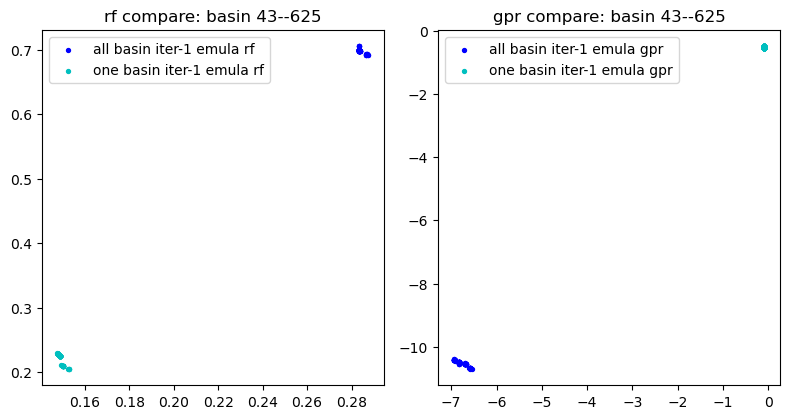

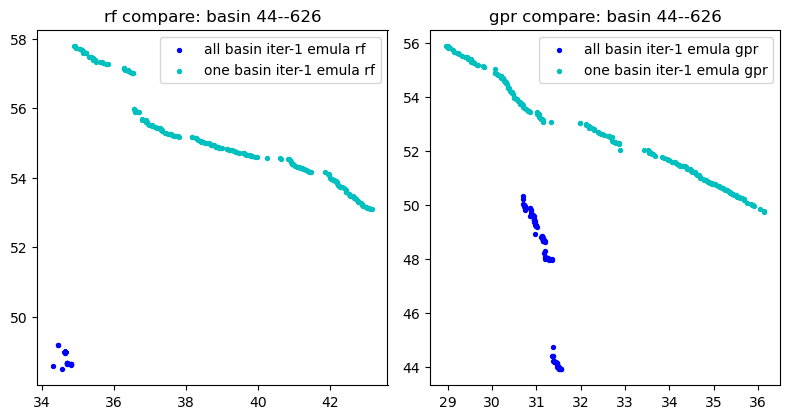

In [59]:
# whether optimized parameters have better performance than original points


for tarbasin in range(len(df_info)):
    index = np.where(df_basinid["basin_num"].values == tarbasin)[0]
    x_tar = x[index, : len(param_names)]
    y_tar = y[index, :]

    fig = plt.figure(figsize=[8, 8])

    # # emulator comparison
    # fig.add_subplot(2,2,1)
    # plt.scatter(y_tar[:, 0], y_tar[:, 1], 10, color='grey', alpha=0.5, label="iter-0")
    # plt.scatter(besty_sm_all_rf[tarbasin][:, 0], besty_sm_all_rf[tarbasin][:, 1], 8, color='b', label="all basin iter-1 emula rf",)
    # plt.scatter(besty_sm_all_gpr[tarbasin][:, 0], besty_sm_all_gpr[tarbasin][:, 1], 8,  color='r', label="all basin iter-1 emula gpr",)
    # plt.scatter(besty_sm_oneb_rf[tarbasin][:, 0], besty_sm_oneb_rf[tarbasin][:, 1], 8, color='c', label="one basin iter-1 emula rf",)
    # plt.scatter(besty_sm_oneb_gpr[tarbasin][:, 0], besty_sm_oneb_gpr[tarbasin][:, 1], 8, color='pink', label="one basin iter-1 emula gpr",)
    # plt.title(f"emulator compare: basin {tarbasin}--{df_basinid['basin_id'].values[index[0]]}")
    # plt.legend()


    # # real model comparison
    # fig.add_subplot(2,2,2)
    # plt.scatter(y_tar[:, 0], y_tar[:, 1], 10, color='grey', alpha=0.5, label="iter-0")
    # index2 = np.where(df_basinid_iter1_rf["basin_num"].values == tarbasin)[0]
    # plt.scatter(df_metric_iter1_rf_allb.values[index2, 0], df_metric_iter1_rf_allb.values[index2, 1], 8, color='b', label="all basin iter-1 ctsm rf")
    # plt.scatter(df_metric_iter1_gpr_allb.values[index2, 0], df_metric_iter1_gpr_allb.values[index2, 1], 8, color='r', label="all basin iter-1 ctsm gpr")
    # plt.scatter(df_metric_iter1_rf.values[index2, 0], df_metric_iter1_rf.values[index2, 1], 8, color='c', label="one basin iter-1 ctsm rf")
    # plt.scatter(df_metric_iter1_gpr.values[index2, 0], df_metric_iter1_gpr.values[index2, 1], 8, color='pink', label="one basin iter-1 ctsm gpr")
    # plt.title(f"ctsm compare: basin {tarbasin}--{df_basinid['basin_id'].values[index[0]]}")
    # plt.legend()

    # all RF in a figure
    fig.add_subplot(2,2,3)
    # plt.scatter(y_tar[:, 0], y_tar[:, 1], 10, color='grey', alpha=0.5, label="iter-0")
    index2 = np.where(df_basinid_iter1_rf["basin_num"].values == tarbasin)[0]
    plt.scatter(besty_sm_all_rf[tarbasin][:, 0], besty_sm_all_rf[tarbasin][:, 1], 8, color='b', label="all basin iter-1 emula rf",)
    plt.scatter(besty_sm_oneb_rf[tarbasin][:, 0], besty_sm_oneb_rf[tarbasin][:, 1], 8, color='c', label="one basin iter-1 emula rf",)
    # plt.scatter(df_metric_iter1_rf_allb.values[index2, 0], df_metric_iter1_rf_allb.values[index2, 1], 8, color='r', label="all basin iter-1 ctsm rf")
    # plt.scatter(df_metric_iter1_rf.values[index2, 0], df_metric_iter1_rf.values[index2, 1], 8, color='pink', label="one basin iter-1 ctsm rf")
    plt.title(f"rf compare: basin {tarbasin}--{df_basinid['basin_id'].values[index[0]]}")
    plt.legend()


    # all gpr in a figure
    fig.add_subplot(2,2,4)
    # plt.scatter(y_tar[:, 0], y_tar[:, 1], 10, color='grey', alpha=0.5, label="iter-0")
    index2 = np.where(df_basinid_iter1_gpr["basin_num"].values == tarbasin)[0]
    plt.scatter(besty_sm_all_gpr[tarbasin][:, 0], besty_sm_all_gpr[tarbasin][:, 1], 8, color='b', label="all basin iter-1 emula gpr",)
    plt.scatter(besty_sm_oneb_gpr[tarbasin][:, 0], besty_sm_oneb_gpr[tarbasin][:, 1], 8, color='c', label="one basin iter-1 emula gpr",)
    # plt.scatter(df_metric_iter1_gpr_allb.values[index2, 0], df_metric_iter1_gpr_allb.values[index2, 1], 8, color='r', label="all basin iter-1 ctsm gpr")
    # plt.scatter(df_metric_iter1_gpr.values[index2, 0], df_metric_iter1_gpr.values[index2, 1], 8, color='pink', label="one basin iter-1 ctsm gpr")
    plt.title(f"gpr compare: basin {tarbasin}--{df_basinid['basin_id'].values[index[0]]}")
    plt.legend()

    plt.tight_layout()
    plt.show()